In [ ]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#from mpl_toolkits.basemap import Basemap
#from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
#pip install basemap

Reading in the flights.csv data to ananlyze the dimensions of the dataset and identify the percentage of null values in each column.

In [7]:
flights_df = pd.read_csv('flights.csv', low_memory=False)
print('Dataframe dimensions:', flights_df.shape)

table_info=pd.DataFrame(flights_df.dtypes).T.rename(index={0:'column type'})
table_info=table_info.append(pd.DataFrame(flights_df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
table_info=table_info.append(pd.DataFrame(flights_df.isnull().sum()/flights_df.shape[0]*100).T.rename(index={0:'null values (%)'}))
table_info

Dataframe dimensions: (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.252978,0.0,0.0,0.0,1.480526,1.480526,1.530259,1.530259,0.000103,1.805629,1.805629,0.0,1.589822,1.589822,0.0,1.589822,1.805629,0.0,0.0,98.455357,81.72496,81.72496,81.72496,81.72496,81.72496


Removing columns with more than 80% values missing and the columns not necessary to our analysis.

In [8]:
variables_to_remove = [ 'AIR_SYSTEM_DELAY','FLIGHT_NUMBER', 'TAIL_NUMBER',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'CANCELLATION_REASON','TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'DAY_OF_WEEK',
                      'DIVERTED', 'CANCELLED', 'AIR_TIME']
flights_df.drop(variables_to_remove, axis = 1, inplace = True)

flights_df[:5]

,YEAR,MONTH,DAY,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,2015,1,1,AS,ANC,SEA,5,2354.0,-11.0,205.0,194.0,1448,430,408.0,-22.0
1,2015,1,1,AA,LAX,PBI,10,2.0,-8.0,280.0,279.0,2330,750,741.0,-9.0
2,2015,1,1,US,SFO,CLT,20,18.0,-2.0,286.0,293.0,2296,806,811.0,5.0
3,2015,1,1,AA,LAX,MIA,20,15.0,-5.0,285.0,281.0,2342,805,756.0,-9.0
4,2015,1,1,AS,SEA,ANC,25,24.0,-1.0,235.0,215.0,1448,320,259.0,-21.0


In [9]:
print('Dataframe dimensions after columns removal:', flights_df.shape)
table_info2=pd.DataFrame(flights_df.dtypes).T.rename(index={0:'column type'})
table_info2=table_info2.append(pd.DataFrame(flights_df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
table_info2=table_info2.append(pd.DataFrame(flights_df.isnull().sum()/flights_df.shape[0]*100).T.rename(index={0:'null values (%)'}))
table_info2

Dataframe dimensions after columns removal: (5819079, 15)


,YEAR,MONTH,DAY,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
column type,int64,int64,int64,object,object,object,int64,float64,float64,float64,float64,int64,int64,float64,float64
null values (nb),0,0,0,0,0,0,0,86153,86153,6,105071,0,0,92513,105071
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.480526,1.480526,0.000103,1.805629,0.0,0.0,1.589822,1.805629


Since only a small fraction of values are missing in the dataset now. We can drop them without imputation.

In [10]:
flights_df.dropna(inplace = True)

In [11]:
print('Dataframe dimensions after missing rows removal:', flights_df.shape)
table_info3=pd.DataFrame(flights_df.dtypes).T.rename(index={0:'column type'})
table_info3=table_info3.append(pd.DataFrame(flights_df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
table_info3=table_info3.append(pd.DataFrame(flights_df.isnull().sum()/flights_df.shape[0]*100).T.rename(index={0:'null values (%)'}))
table_info3

Dataframe dimensions after missing rows removal: (5714008, 15)


,YEAR,MONTH,DAY,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
column type,int64,int64,int64,object,object,object,int64,float64,float64,float64,float64,int64,int64,float64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Reading airports.csv data to plot the airport locations and visualize the number of flights operating at each one of them.

In [12]:
airports_df = pd.read_csv("airports.csv")
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [13]:
merged_df = pd.merge(flights_df, airports_df, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')
origin_counts = merged_df['ORIGIN_AIRPORT'].value_counts().reset_index()
origin_counts.columns = ['IATA_CODE', 'FLIGHT_COUNT']
airport_locations = merged_df[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].drop_duplicates()
plot_df = pd.merge(origin_counts, airport_locations, on='IATA_CODE')

In [14]:
m = Basemap(
    projection='merc',
    llcrnrlat=20,
    urcrnrlat=50,
    llcrnrlon=-130,
    urcrnrlon=-60,
    lat_ts=20,
    resolution='i'
)
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='white', lake_color='lightblue')
m.drawstates(color='black')
m.drawcountries(linewidth = 1)
m.scatter(
    plot_df['LONGITUDE'].values,
    plot_df['LATITUDE'].values,
    latlon=True,
    c=plot_df['FLIGHT_COUNT'].values,
    cmap=plt.get_cmap('jet'),
    alpha=0.5
)


plt.colorbar()

lat_lon_factor = 10  
lat_size = (m.urcrnrlat - m.llcrnrlat) * lat_lon_factor
lon_size = (m.urcrnrlon - m.llcrnrlon) * lat_lon_factor
map_size = max(lat_size, lon_size)
font_size = int(map_size / 50)
plt.title("Originating Flights in the US for 2015", fontsize=font_size)


plt.show()

NameError: name 'Basemap' is not defined

Converting YEAR, MONTH and DAY columns to just DATE.

In [15]:
flights_df['DATE'] = pd.to_datetime(flights_df[['YEAR', 'MONTH', 'DAY']])

In [16]:
#This will be the dataframe we'll use for analysis
flight_analysis_df = flights_df[[ 'DATE', 'AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE',
                         'DEPARTURE_TIME','DEPARTURE_DELAY','SCHEDULED_TIME','ELAPSED_TIME','DISTANCE',
                         'SCHEDULED_ARRIVAL','ARRIVAL_TIME','ARRIVAL_DELAY']]
flight_analysis_df.head(10)

,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,2015-01-01,AS,ANC,SEA,5,2354.0,-11.0,205.0,194.0,1448,430,408.0,-22.0
1,2015-01-01,AA,LAX,PBI,10,2.0,-8.0,280.0,279.0,2330,750,741.0,-9.0
2,2015-01-01,US,SFO,CLT,20,18.0,-2.0,286.0,293.0,2296,806,811.0,5.0
3,2015-01-01,AA,LAX,MIA,20,15.0,-5.0,285.0,281.0,2342,805,756.0,-9.0
4,2015-01-01,AS,SEA,ANC,25,24.0,-1.0,235.0,215.0,1448,320,259.0,-21.0
5,2015-01-01,DL,SFO,MSP,25,20.0,-5.0,217.0,230.0,1589,602,610.0,8.0
6,2015-01-01,NK,LAS,MSP,25,19.0,-6.0,181.0,170.0,1299,526,509.0,-17.0
7,2015-01-01,US,LAX,CLT,30,44.0,14.0,273.0,249.0,2125,803,753.0,-10.0
8,2015-01-01,AA,SFO,DFW,30,19.0,-11.0,195.0,193.0,1464,545,532.0,-13.0
9,2015-01-01,DL,LAS,ATL,30,33.0,3.0,221.0,203.0,1747,711,656.0,-15.0


Converting columns that contain time to relevant type.

In [17]:
flight_analysis_df['SCHEDULED_DEPARTURE_TIME'] = pd.to_datetime(flight_analysis_df['SCHEDULED_DEPARTURE'].astype(str).str.zfill(4), format='%H%M').dt.time
flight_analysis_df.drop(columns=['SCHEDULED_DEPARTURE'], inplace=True)

In [18]:
flight_analysis_df['DEPARTURE_TIME'] = flight_analysis_df['DEPARTURE_TIME'].astype(int)
flight_analysis_df['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(flight_analysis_df['DEPARTURE_TIME'].astype(str).str.zfill(4), format='%H%M', errors='coerce').dt.time
flight_analysis_df.drop(columns=['DEPARTURE_TIME'], inplace=True)

In [19]:
flight_analysis_df['SCHEDULED_ARRIVAL_TIME'] = pd.to_datetime(flight_analysis_df['SCHEDULED_ARRIVAL'].astype(str).str.zfill(4), format='%H%M',errors='coerce').dt.time
flight_analysis_df.drop(columns=['SCHEDULED_ARRIVAL'], inplace=True)

In [20]:
flight_analysis_df['ARRIVAL_TIME'] = flight_analysis_df['ARRIVAL_TIME'].astype(int)
flight_analysis_df['ACTUAL_ARRIVAL_TIME'] = pd.to_datetime(flight_analysis_df['ARRIVAL_TIME'].astype(str).str.zfill(4), format='%H%M', errors='coerce').dt.time
flight_analysis_df.drop(columns=['ARRIVAL_TIME'], inplace=True)

In [21]:
flight_analysis_df= flight_analysis_df[['DATE','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE_TIME','ACTUAL_DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL_TIME', 'ACTUAL_ARRIVAL_TIME', 'ARRIVAL_DELAY','SCHEDULED_TIME', 'ELAPSED_TIME','DISTANCE']]


In [22]:
airlines_names_df = pd.read_csv('airlines.csv')
airlines_names_df.columns = ['IATA_CODE', 'AIRLINE_NAME']
airlines_names_df

,IATA_CODE,AIRLINE_NAME
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


Visualizing departure delay by airline.

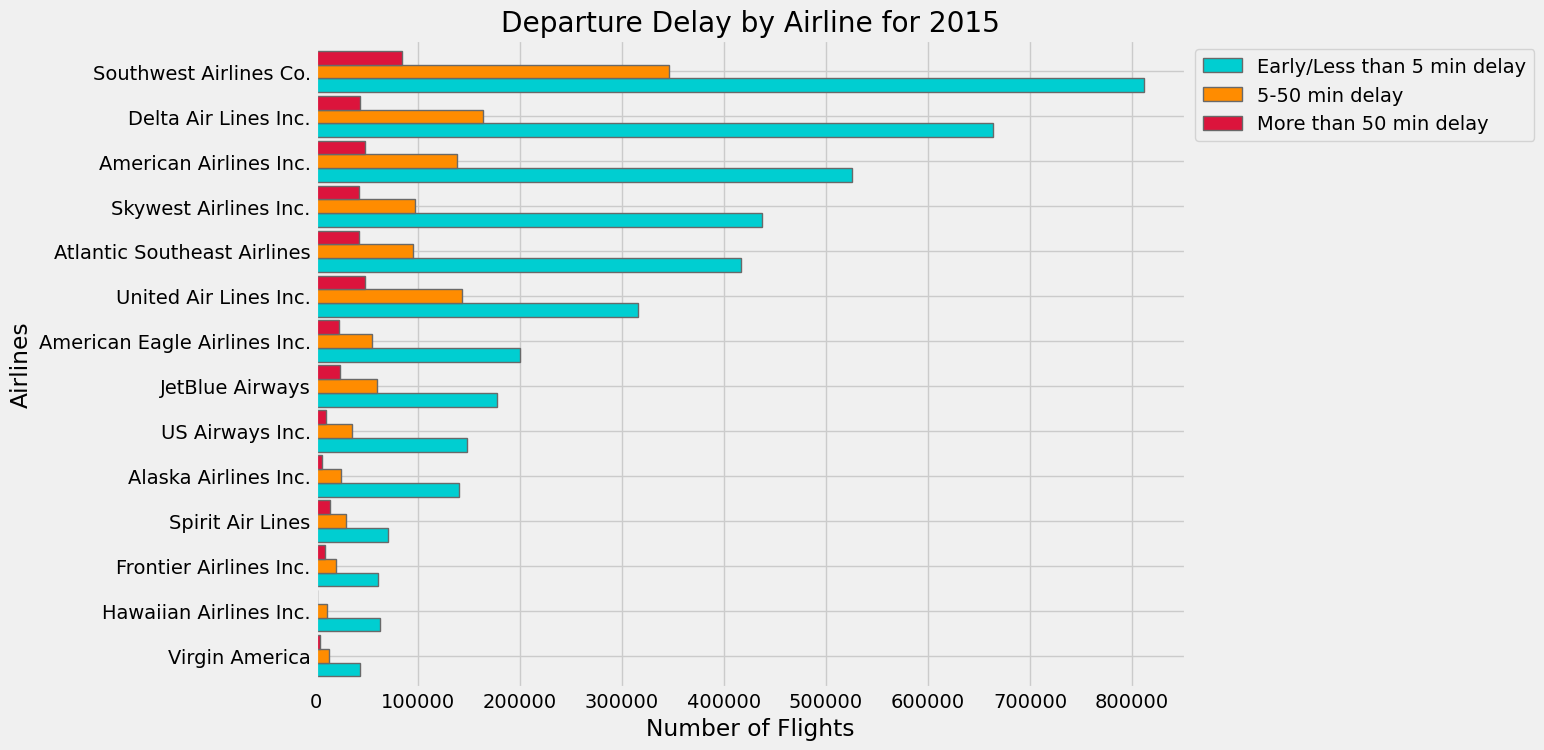

In [23]:

airlines_merged_df = pd.merge(flight_analysis_df, airlines_names_df, left_on='AIRLINE', right_on='IATA_CODE')

ranges = [(float('-inf'), 5), (5, 50), (50, float('inf'))]

def assign_range(x):
    for i, (lower, upper) in enumerate(ranges):
        if x >= lower and x < upper:
            return i
    raise ValueError(f'Invalid value: {x}')

airlines_merged_df['DEPARTURE_DELAY_RANGE'] = airlines_merged_df['DEPARTURE_DELAY'].apply(assign_range)

airlines_grouped_df = airlines_merged_df.groupby(['AIRLINE_NAME', 'DEPARTURE_DELAY_RANGE']).size().unstack()

airlines_grouped_df.columns = ['Early/Less than 5 min delay', '5-50 min delay', 'More than 50 min delay']

airlines_grouped_df = airlines_grouped_df.loc[airlines_grouped_df.sum(axis=1).sort_values().index]

ax = airlines_grouped_df.plot.barh(stacked=False, figsize=(10, 8),
                                   color=['darkturquoise', 'darkorange', 'crimson'], width=0.92)

ax.set_xlabel('Number of Flights')
ax.set_ylabel('Airlines')

ax.set_title('Departure Delay by Airline for 2015')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

Visualizing arrival delay by airline.

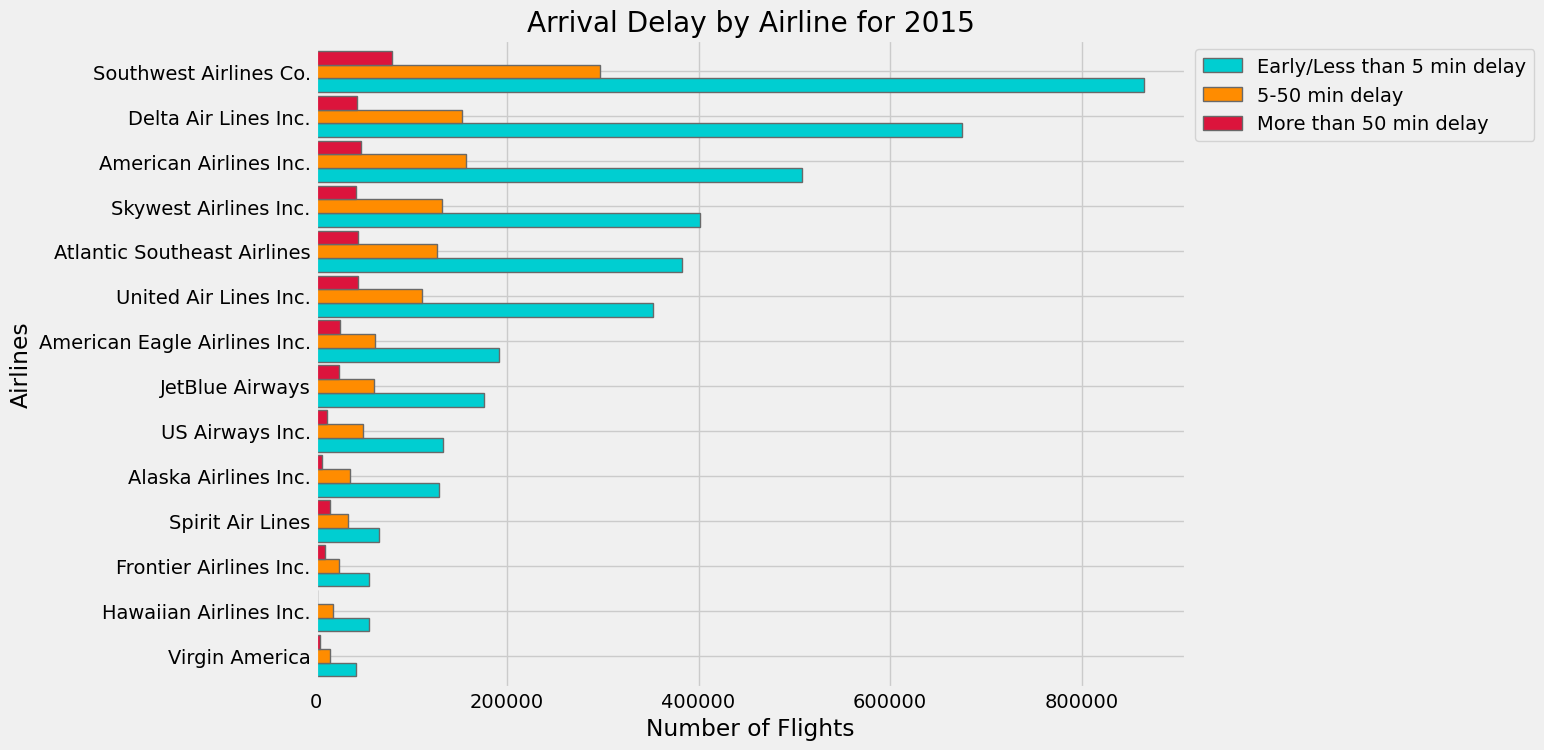

In [24]:
airlines_merged_df['ARRIVAL_DELAY_RANGE'] = airlines_merged_df['ARRIVAL_DELAY'].apply(assign_range)

airlines_grouped_df2 = airlines_merged_df.groupby(['AIRLINE_NAME', 'ARRIVAL_DELAY_RANGE']).size().unstack()

airlines_grouped_df2.columns = ['Early/Less than 5 min delay', '5-50 min delay', 'More than 50 min delay']

airlines_grouped_df2 = airlines_grouped_df2.loc[airlines_grouped_df2.sum(axis=1).sort_values().index]

ax = airlines_grouped_df2.plot.barh(stacked=False, figsize=(10, 8),
                                    color=['darkturquoise', 'darkorange', 'crimson'], width=0.92)

ax.set_xlabel('Number of Flights')
ax.set_ylabel('Airlines')

ax.set_title('Arrival Delay by Airline for 2015')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

Adding origin and destination city and state data to the dataset.

In [25]:
flight_analysis_df = pd.merge(flight_analysis_df, airports_df[['IATA_CODE', 'CITY', 'STATE']], left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')
flight_analysis_df = pd.merge(flight_analysis_df, airports_df[['IATA_CODE', 'CITY', 'STATE']], left_on='DESTINATION_AIRPORT', right_on='IATA_CODE')

flight_analysis_df = flight_analysis_df.rename(columns={'CITY_x': 'ORIGIN_CITY', 'STATE_x': 'ORIGIN_STATE', 'CITY_y': 'DESTINATION_CITY', 'STATE_y': 'DESTINATION_STATE'})

In [26]:
flight_analysis_df= flight_analysis_df.drop(['IATA_CODE_x', 'IATA_CODE_y'], axis=1)
flight_analysis_df= flight_analysis_df[['DATE','AIRLINE','ORIGIN_AIRPORT', 'ORIGIN_CITY','ORIGIN_STATE',
                                        'DESTINATION_AIRPORT','DESTINATION_CITY','DESTINATION_STATE','SCHEDULED_DEPARTURE_TIME','ACTUAL_DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL_TIME', 'ACTUAL_ARRIVAL_TIME', 'ARRIVAL_DELAY','SCHEDULED_TIME', 'ELAPSED_TIME','DISTANCE']]


In [27]:
flight_analysis_df

,DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,DESTINATION_AIRPORT,DESTINATION_CITY,DESTINATION_STATE,SCHEDULED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE
0,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0,1448
1,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,00:45:00,00:41:00,-4.0,05:09:00,04:55:00,-14.0,204.0,194.0,1448
2,2015-01-01,DL,ANC,Anchorage,AK,SEA,Seattle,WA,00:45:00,00:31:00,-14.0,05:15:00,04:51:00,-24.0,210.0,200.0,1448
3,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,01:55:00,01:40:00,-15.0,06:33:00,05:58:00,-35.0,218.0,198.0,1448
4,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,02:20:00,02:09:00,-11.0,06:40:00,06:28:00,-12.0,200.0,199.0,1448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231125,2015-12-29,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,23:56:00,23:35:00,-21.0,00:45:00,00:20:00,-25.0,49.0,45.0,83
5231126,2015-12-30,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,14:31:00,14:19:00,-12.0,15:16:00,14:57:00,-19.0,45.0,38.0,83
5231127,2015-12-30,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,23:56:00,23:23:00,-33.0,00:45:00,00:11:00,-34.0,49.0,48.0,83
5231128,2015-12-31,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,14:31:00,14:31:00,0.0,15:16:00,15:33:00,17.0,45.0,62.0,83


### Converting all time columns to EST for consistency.

In [28]:
from dateutil import tz

# create a dictionary of state abbreviations and their corresponding time zones
state_tz = {'AL': 'US/Central', 'AK': 'US/Alaska', 'AZ': 'US/Arizona', 'AR': 'US/Central',
            'CA': 'US/Pacific', 'CO': 'US/Mountain', 'CT': 'US/Eastern', 'DE': 'US/Eastern',
            'DC': 'US/Eastern', 'FL': 'US/Eastern', 'GA': 'US/Eastern', 'HI': 'US/Hawaii',
            'ID': 'US/Mountain', 'IL': 'US/Central', 'IN': 'US/Eastern', 'IA': 'US/Central',
            'KS': 'US/Central', 'KY': 'US/Eastern', 'LA': 'US/Central', 'ME': 'US/Eastern',
            'MD': 'US/Eastern', 'MA': 'US/Eastern', 'MI': 'US/Eastern', 'MN': 'US/Central',
            'MS': 'US/Central', 'MO': 'US/Central', 'MT': 'US/Mountain', 'NE': 'US/Central',
            'NV': 'US/Pacific', 'NH': 'US/Eastern', 'NJ': 'US/Eastern', 'NM': 'US/Mountain',
            'NY': 'US/Eastern', 'NC': 'US/Eastern', 'ND': 'US/Central', 'OH': 'US/Eastern',
            'OK': 'US/Central', 'OR': 'US/Pacific', 'PA': 'US/Eastern', 'RI': 'US/Eastern',
            'SC': 'US/Eastern', 'SD': 'US/Central', 'TN': 'US/Central', 'TX': 'US/Central',
            'UT': 'US/Mountain', 'VT': 'US/Eastern', 'VA': 'US/Eastern', 'WA': 'US/Pacific',
            'WV': 'US/Eastern', 'WI': 'US/Central', 'WY': 'US/Mountain'}

# add a new column with the time zone for the origin state
flight_analysis_df['ORIGIN_STATE_TZ'] = flight_analysis_df['ORIGIN_STATE'].map(state_tz)

# add a new column with the time zone for the destination state
flight_analysis_df['DESTINATION_STATE_TZ'] = flight_analysis_df['DESTINATION_STATE'].map(state_tz)

In [29]:
import pytz
from datetime import datetime, time, timedelta

def convert_to_est(dt, tz):
    local_time = tz.localize(dt)
    est_tz = pytz.timezone('US/Eastern')
    est_time = local_time.astimezone(est_tz)
    
    return est_time

In [30]:
flight_analysis_df.dropna(inplace = True)

In [31]:
flight_analysis_df['SCHEDULED_DEPARTURE_TIME_EST'] = flight_analysis_df.apply(lambda x: convert_to_est(datetime.combine(x['DATE'], x['SCHEDULED_DEPARTURE_TIME']), pytz.timezone(x['ORIGIN_STATE_TZ'])), axis=1)

KeyboardInterrupt: 

In [27]:
flight_analysis_df['SCHEDULED_ARRIVAL_TIME_EST'] = flight_analysis_df.apply(lambda x: convert_to_est(datetime.combine(x['DATE'], x['SCHEDULED_ARRIVAL_TIME']), pytz.timezone(x['DESTINATION_STATE_TZ'])), axis=1)

In [28]:
flight_analysis_df

,DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,DESTINATION_AIRPORT,DESTINATION_CITY,DESTINATION_STATE,SCHEDULED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,ORIGIN_STATE_TZ,DESTINATION_STATE_TZ,SCHEDULED_DEPARTURE_TIME_EST,SCHEDULED_ARRIVAL_TIME_EST
0,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0,1448,US/Alaska,US/Pacific,2015-01-01 04:05:00-05:00,2015-01-01 07:30:00-05:00
1,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,00:45:00,00:41:00,-4.0,05:09:00,04:55:00,-14.0,204.0,194.0,1448,US/Alaska,US/Pacific,2015-01-01 04:45:00-05:00,2015-01-01 08:09:00-05:00
2,2015-01-01,DL,ANC,Anchorage,AK,SEA,Seattle,WA,00:45:00,00:31:00,-14.0,05:15:00,04:51:00,-24.0,210.0,200.0,1448,US/Alaska,US/Pacific,2015-01-01 04:45:00-05:00,2015-01-01 08:15:00-05:00
3,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,01:55:00,01:40:00,-15.0,06:33:00,05:58:00,-35.0,218.0,198.0,1448,US/Alaska,US/Pacific,2015-01-01 05:55:00-05:00,2015-01-01 09:33:00-05:00
4,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,02:20:00,02:09:00,-11.0,06:40:00,06:28:00,-12.0,200.0,199.0,1448,US/Alaska,US/Pacific,2015-01-01 06:20:00-05:00,2015-01-01 09:40:00-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231125,2015-12-29,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,23:56:00,23:35:00,-21.0,00:45:00,00:20:00,-25.0,49.0,45.0,83,US/Central,US/Central,2015-12-30 00:56:00-05:00,2015-12-29 01:45:00-05:00
5231126,2015-12-30,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,14:31:00,14:19:00,-12.0,15:16:00,14:57:00,-19.0,45.0,38.0,83,US/Central,US/Central,2015-12-30 15:31:00-05:00,2015-12-30 16:16:00-05:00
5231127,2015-12-30,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,23:56:00,23:23:00,-33.0,00:45:00,00:11:00,-34.0,49.0,48.0,83,US/Central,US/Central,2015-12-31 00:56:00-05:00,2015-12-30 01:45:00-05:00
5231128,2015-12-31,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,14:31:00,14:31:00,0.0,15:16:00,15:33:00,17.0,45.0,62.0,83,US/Central,US/Central,2015-12-31 15:31:00-05:00,2015-12-31 16:16:00-05:00


### Adding regions columns for dataset division.

In [29]:
region_map = {
    'CT': 'Northeast',
    'ME': 'Northeast',
    'MA': 'Northeast',
    'NH': 'Northeast',
    'RI': 'Northeast',
    'VT': 'Northeast',
    'NJ': 'Northeast',
    'NY': 'Northeast',
    'PA': 'Northeast',
    'IL': 'Midwest',
    'IN': 'Midwest',
    'MI': 'Midwest',
    'OH': 'Midwest',
    'WI': 'Midwest',
    'IA': 'Midwest',
    'KS': 'Midwest',
    'MN': 'Midwest',
    'MO': 'Midwest',
    'NE': 'Midwest',
    'ND': 'Midwest',
    'SD': 'Midwest',
    'DE': 'South',
    'FL': 'South',
    'GA': 'South',
    'MD': 'South',
    'NC': 'South',
    'SC': 'South',
    'VA': 'South',
    'WV': 'South',
    'AL': 'South',
    'KY': 'South',
    'MS': 'South',
    'TN': 'South',
    'AR': 'South',
    'LA': 'South',
    'OK': 'South',
    'TX': 'South',
    'AZ': 'West',
    'CO': 'West',
    'ID': 'West',
    'MT': 'West',
    'NV': 'West',
    'NM': 'West',
    'UT': 'West',
    'WY': 'West',
    'AK': 'West',
    'CA': 'West',
    'HI': 'West',
    'OR': 'West',
    'WA': 'West',
}

flight_analysis_df['ORIGIN_REGION'] = flight_analysis_df['ORIGIN_STATE'].map(region_map)
flight_analysis_df['DESTINATION_REGION'] = flight_analysis_df['DESTINATION_STATE'].map(region_map)

In [30]:
flight_analysis_df

,DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,DESTINATION_AIRPORT,DESTINATION_CITY,DESTINATION_STATE,SCHEDULED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,ORIGIN_STATE_TZ,DESTINATION_STATE_TZ,SCHEDULED_DEPARTURE_TIME_EST,SCHEDULED_ARRIVAL_TIME_EST,ORIGIN_REGION,DESTINATION_REGION
0,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0,1448,US/Alaska,US/Pacific,2015-01-01 04:05:00-05:00,2015-01-01 07:30:00-05:00,West,West
1,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,00:45:00,00:41:00,-4.0,05:09:00,04:55:00,-14.0,204.0,194.0,1448,US/Alaska,US/Pacific,2015-01-01 04:45:00-05:00,2015-01-01 08:09:00-05:00,West,West
2,2015-01-01,DL,ANC,Anchorage,AK,SEA,Seattle,WA,00:45:00,00:31:00,-14.0,05:15:00,04:51:00,-24.0,210.0,200.0,1448,US/Alaska,US/Pacific,2015-01-01 04:45:00-05:00,2015-01-01 08:15:00-05:00,West,West
3,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,01:55:00,01:40:00,-15.0,06:33:00,05:58:00,-35.0,218.0,198.0,1448,US/Alaska,US/Pacific,2015-01-01 05:55:00-05:00,2015-01-01 09:33:00-05:00,West,West
4,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,02:20:00,02:09:00,-11.0,06:40:00,06:28:00,-12.0,200.0,199.0,1448,US/Alaska,US/Pacific,2015-01-01 06:20:00-05:00,2015-01-01 09:40:00-05:00,West,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231125,2015-12-29,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,23:56:00,23:35:00,-21.0,00:45:00,00:20:00,-25.0,49.0,45.0,83,US/Central,US/Central,2015-12-30 00:56:00-05:00,2015-12-29 01:45:00-05:00,Midwest,Midwest
5231126,2015-12-30,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,14:31:00,14:19:00,-12.0,15:16:00,14:57:00,-19.0,45.0,38.0,83,US/Central,US/Central,2015-12-30 15:31:00-05:00,2015-12-30 16:16:00-05:00,Midwest,Midwest
5231127,2015-12-30,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,23:56:00,23:23:00,-33.0,00:45:00,00:11:00,-34.0,49.0,48.0,83,US/Central,US/Central,2015-12-31 00:56:00-05:00,2015-12-30 01:45:00-05:00,Midwest,Midwest
5231128,2015-12-31,OO,JMS,Jamestown,ND,DVL,Devils Lake,ND,14:31:00,14:31:00,0.0,15:16:00,15:33:00,17.0,45.0,62.0,83,US/Central,US/Central,2015-12-31 15:31:00-05:00,2015-12-31 16:16:00-05:00,Midwest,Midwest


In [31]:
unique_regions = flight_analysis_df.groupby(['ORIGIN_REGION', 'DESTINATION_REGION']).size().reset_index(name='count')
unique_regions

,ORIGIN_REGION,DESTINATION_REGION,count
0,Midwest,Midwest,338459
1,Midwest,Northeast,113962
2,Midwest,South,318368
3,Midwest,West,174216
4,Northeast,Midwest,113679
5,Northeast,Northeast,76649
6,Northeast,South,295128
7,Northeast,West,93824
8,South,Midwest,318992
9,South,Northeast,294477


The dataset covers all possible combinations of regions. Dividing the dataframe to unique region pairs irrespective of their order.

Flights within the Midwest:

In [35]:
flights_MW = flight_analysis_df[(flight_analysis_df['ORIGIN_REGION'] == 'Midwest') & (flight_analysis_df['DESTINATION_REGION'] == 'Midwest')]

Flights within the Northeast:

In [36]:
flights_NE = flight_analysis_df[(flight_analysis_df['ORIGIN_REGION'] == 'Northeast') & (flight_analysis_df['DESTINATION_REGION'] == 'Northeast')]

Flights within the South:

In [37]:
flights_S = flight_analysis_df[(flight_analysis_df['ORIGIN_REGION'] == 'South') & (flight_analysis_df['DESTINATION_REGION'] == 'South')]

Flights within the West:

In [38]:
flights_W = flight_analysis_df[(flight_analysis_df['ORIGIN_REGION'] == 'West') & (flight_analysis_df['DESTINATION_REGION'] == 'West')]

Flights between the Midwest and the Northeast:

In [39]:
flights_MW_NE = flight_analysis_df[(flight_analysis_df['ORIGIN_REGION'] == 'Northeast') & (flight_analysis_df['DESTINATION_REGION'] == 'Midwest') | (flight_analysis_df['ORIGIN_REGION'] == 'Midwest') & (flight_analysis_df['DESTINATION_REGION'] == 'Northeast')]

Flights between the Midwest and the South:

In [41]:
flights_MW_S = flight_analysis_df[(flight_analysis_df['ORIGIN_REGION'] == 'South') & (flight_analysis_df['DESTINATION_REGION'] == 'Midwest') | (flight_analysis_df['ORIGIN_REGION'] == 'Midwest') & (flight_analysis_df['DESTINATION_REGION'] == 'South')]

Flights between the Midwest and the West:

In [42]:
flights_MW_W = flight_analysis_df[(flight_analysis_df['ORIGIN_REGION'] == 'West') & (flight_analysis_df['DESTINATION_REGION'] == 'Midwest') | (flight_analysis_df['ORIGIN_REGION'] == 'Midwest') & (flight_analysis_df['DESTINATION_REGION'] == 'West')]

Flights between the Northeast and the South:

In [43]:
flights_NE_S = flight_analysis_df[(flight_analysis_df['ORIGIN_REGION'] == 'Northeast') & (flight_analysis_df['DESTINATION_REGION'] == 'South') | (flight_analysis_df['ORIGIN_REGION'] == 'South') & (flight_analysis_df['DESTINATION_REGION'] == 'Northeast')]

Flights between the Northeast and the West:

In [44]:
flights_NE_W = flight_analysis_df[(flight_analysis_df['ORIGIN_REGION'] == 'Northeast') & (flight_analysis_df['DESTINATION_REGION'] == 'West') | (flight_analysis_df['ORIGIN_REGION'] == 'West') & (flight_analysis_df['DESTINATION_REGION'] == 'Northeast')]

Flights between the South and the West:

In [45]:
flights_S_W = flight_analysis_df[(flight_analysis_df['ORIGIN_REGION'] == 'West') & (flight_analysis_df['DESTINATION_REGION'] == 'South') | (flight_analysis_df['ORIGIN_REGION'] == 'South') & (flight_analysis_df['DESTINATION_REGION'] == 'West')]

### Building multiple linear regression models based on the regions.

#### Midwest

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_MW = flights_MW[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
y_MW = flights_MW['DEPARTURE_DELAY']

X_MW = pd.get_dummies(X_MW, columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])

# Split the data into training and cross-validation sets
X_train_MW, X_test_MW, y_train_MW, y_test_MW = train_test_split(X_MW, y_MW, test_size=0.3, random_state=42)

# Create and train the linear regression model
model_MW = LinearRegression()
model_MW.fit(X_train_MW, y_train_MW)

# Evaluate the model on the test set
y_test_pred_MW = model_MW.predict(X_test_MW)
mse_MW = mean_squared_error(y_test_MW, y_test_pred_MW)
print(f"Mean Squared Error on test set (Midwest): {mse_MW}")
r2_MW = r2_score(y_test_MW, y_test_pred_MW)
print(f"R-squared on test set (Midwest): {r2_MW}")

Mean Squared Error on test set (Midwest): 1502.8237846550485
R-squared on test set (Midwest): 0.008349676605555745


Checking the summary of the model

In [61]:
import statsmodels.api as sm


# Define the features and response
X = flights_MW[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
y = flights_MW['DEPARTURE_DELAY']

# Encode categorical features using one-hot encoding
X = pd.get_dummies(X, columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])

# Add a constant column to X for the intercept
X = sm.add_constant(X)

# Fit the multiple linear regression model using statsmodels
model = sm.OLS(y, X)
results = model.fit()

# Display a summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        DEPARTURE_DELAY   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     20.51
Date:                Sun, 19 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:47:24   Log-Likelihood:            -1.7162e+06
No. Observations:              338459   AIC:                         3.433e+06
Df Residuals:                  338310   BIC:                         3.434e+06
Df Model:                         148                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    5

#### Northeast

In [56]:
X_NE = flights_NE[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
y_NE = flights_NE['DEPARTURE_DELAY']

X_NE = pd.get_dummies(X_NE, columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])

# Split the data into training and cross-validation sets
X_train_NE, X_test_NE, y_train_NE, y_test_NE = train_test_split(X_NE, y_NE, test_size=0.3, random_state=42)

# Create and train the linear regression model
model_NE = LinearRegression()
model_NE.fit(X_train_NE, y_train_NE)

# Evaluate the model on the test set
y_test_pred_NE = model_NE.predict(X_test_NE)
mse_NE = mean_squared_error(y_test_NE, y_test_pred_NE)
print(f"Mean Squared Error on test set (Northeast): {mse_NE}")
r2_NE = r2_score(y_test_NE, y_test_pred_NE)
print(f"R-squared on test set (Northeast): {r2_NE}")

Mean Squared Error on test set (Northeast): 1502.3133606554245
R-squared on test set (Northeast): 0.006896224261943584


In [33]:
flight_analysis_df.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,DESTINATION_AIRPORT,DESTINATION_CITY,DESTINATION_STATE,SCHEDULED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,ORIGIN_STATE_TZ,DESTINATION_STATE_TZ
0,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0,1448,US/Alaska,US/Pacific
1,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,00:45:00,00:41:00,-4.0,05:09:00,04:55:00,-14.0,204.0,194.0,1448,US/Alaska,US/Pacific
2,2015-01-01,DL,ANC,Anchorage,AK,SEA,Seattle,WA,00:45:00,00:31:00,-14.0,05:15:00,04:51:00,-24.0,210.0,200.0,1448,US/Alaska,US/Pacific
3,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,01:55:00,01:40:00,-15.0,06:33:00,05:58:00,-35.0,218.0,198.0,1448,US/Alaska,US/Pacific
4,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,02:20:00,02:09:00,-11.0,06:40:00,06:28:00,-12.0,200.0,199.0,1448,US/Alaska,US/Pacific


In [34]:
print(flight_analysis_df.columns)

Index(['DATE', 'AIRLINE', 'ORIGIN_AIRPORT', 'ORIGIN_CITY', 'ORIGIN_STATE',
       'DESTINATION_AIRPORT', 'DESTINATION_CITY', 'DESTINATION_STATE',
       'SCHEDULED_DEPARTURE_TIME', 'ACTUAL_DEPARTURE_TIME', 'DEPARTURE_DELAY',
       'SCHEDULED_ARRIVAL_TIME', 'ACTUAL_ARRIVAL_TIME', 'ARRIVAL_DELAY',
       'SCHEDULED_TIME', 'ELAPSED_TIME', 'DISTANCE', 'ORIGIN_STATE_TZ',
       'DESTINATION_STATE_TZ'],
      dtype='object')


In [36]:
from sklearn.linear_model import LinearRegression
X = flight_analysis_df[['DISTANCE']]
y = flight_analysis_df['DEPARTURE_DELAY']

# create a linear regression model and fit it to the data
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [38]:
r_squared = model.score(X, y)
print('R-squared value:', r_squared)

prediction = model.predict([[1000]])

# print the predicted delay in departur
print('Predicted delay in departure for a 1000-mile flight:', prediction[0])

R-squared value: 0.0005359305426128058
Predicted delay in departure for a 1000-mile flight: 9.925979868128259


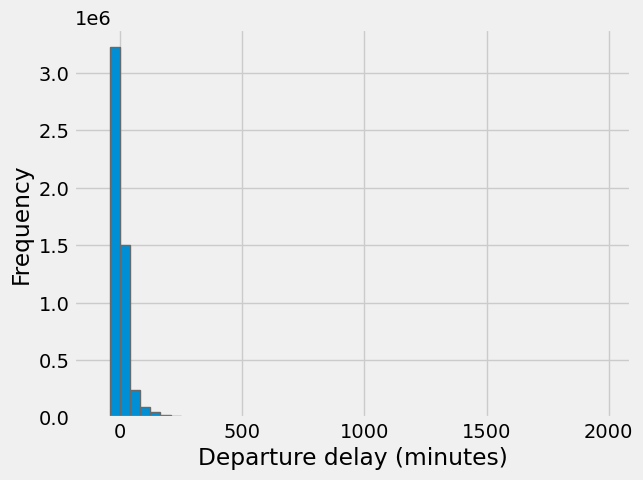

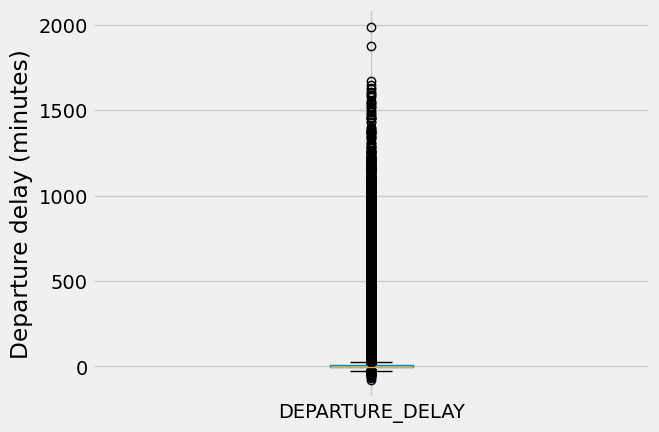

In [43]:
# plot a histogram of DEPARTURE_DELAY
flight_analysis_df['DEPARTURE_DELAY'].hist(bins=50)
plt.xlabel('Departure delay (minutes)')
plt.ylabel('Frequency')
plt.show()

# plot a box plot of DEPARTURE_DELAY
flight_analysis_df.boxplot(column='DEPARTURE_DELAY')
plt.ylabel('Departure delay (minutes)')
plt.show()


KeyboardInterrupt: 

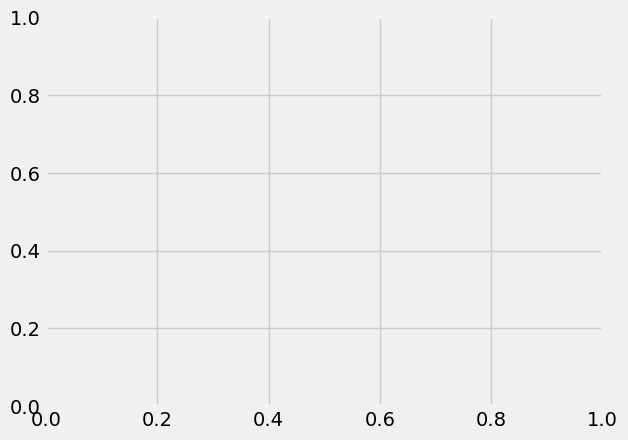

In [44]:
# plot a kernel density plot of DEPARTURE_DELAY
flight_analysis_df['DEPARTURE_DELAY'].plot(kind='kde')
plt.xlabel('Departure delay (minutes)')
plt.show()

In [45]:
flight_analysis_df['departure_status'] = flight_analysis_df['DEPARTURE_DELAY'].apply(lambda x: 0 if x <= 15 else 1)

In [46]:
flight_analysis_df.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,DESTINATION_AIRPORT,DESTINATION_CITY,DESTINATION_STATE,SCHEDULED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,ORIGIN_STATE_TZ,DESTINATION_STATE_TZ,departure_status
0,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0,1448,US/Alaska,US/Pacific,0
1,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,00:45:00,00:41:00,-4.0,05:09:00,04:55:00,-14.0,204.0,194.0,1448,US/Alaska,US/Pacific,0
2,2015-01-01,DL,ANC,Anchorage,AK,SEA,Seattle,WA,00:45:00,00:31:00,-14.0,05:15:00,04:51:00,-24.0,210.0,200.0,1448,US/Alaska,US/Pacific,0
3,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,01:55:00,01:40:00,-15.0,06:33:00,05:58:00,-35.0,218.0,198.0,1448,US/Alaska,US/Pacific,0
4,2015-01-01,AS,ANC,Anchorage,AK,SEA,Seattle,WA,02:20:00,02:09:00,-11.0,06:40:00,06:28:00,-12.0,200.0,199.0,1448,US/Alaska,US/Pacific,0


In [47]:
mean_departure_delay = flight_analysis_df.groupby('departure_status')['DEPARTURE_DELAY'].mean()
print(mean_departure_delay)

departure_status
0    -1.84576
1    61.41333
Name: DEPARTURE_DELAY, dtype: float64


In [58]:
# perform one-hot encoding on the 'color' feature
one_hot_encoded = pd.get_dummies(flight_analysis_df['ORIGIN_AIRPORT'])

# concatenate the one-hot encoded features with the original DataFrame
flight_analysis_df_final = pd.concat([flight_analysis_df[['DISTANCE','departure_status']], one_hot_encoded], axis=1)

flight_analysis_df_final.head()

,DISTANCE,departure_status,ABE,ABI,ABQ,ABR,ABY,ACK,ACT,ACV,ACY,ADK,ADQ,AEX,AGS,AKN,ALB,ALO,AMA,ANC,APN,ASE,ATL,ATW,AUS,...,SUN,SUX,SWF,SYR,TLH,TOL,TPA,TRI,TTN,TUL,TUS,TVC,TWF,TXK,TYR,TYS,UST,VEL,VLD,VPS,WRG,WYS,XNA,YAK,YUM
0,1448,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1448,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1448,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1448,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1448,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# split data into training and testing sets
#X = flight_analysis_df_final[['DISTANCE','SCHEDULED_TIME']]#
X = flight_analysis_df_final.drop(['departure_status'], axis=1) # features
y = flight_analysis_df_final['departure_status'] # response variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a decision tree classifier model
clf = DecisionTreeClassifier(random_state=42)

# fit the model to the training data
clf.fit(X_train, y_train)

# make predictions using the testing data
y_pred = clf.predict(X_test)

# evaluate model performance using classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      1.00      0.90    844905
           1       0.39      0.00      0.00    188354

    accuracy                           0.82   1033259
   macro avg       0.61      0.50      0.45   1033259
weighted avg       0.74      0.82      0.74   1033259



# The above sumamry of results showed that we had an issue in recall and f1-score. This prompted us to resolve the issue of class imbalanced data.